# ACTA 4. Limpieza y Análisis exploratorio de los datos. Parte II

En esta entrega se pretende realizar un análisis exploratorio y limpieza de nuestro conjunto de datos resultante de haber aplicado el preprocesado del ACTA 3. Preprocesado de los datos,  sobre el conjunto de datos limpiado en el ACTA 2. Limpieza y Análisis exploratorio de los datos. Parte I. 

## Índice
- [Importación de librerías y carga de datos](#Importación-de-librerías-y-carga-de-los-datos)
- [Exploración superficial del conjunto de datos](#Exploración-superficial-del-conjunto-de-datos)
- [Análisis exploratorio variables calculadas](#Análisis-exploratorio-variables-calculadas)
    - [Neighborhood](#Neighborhood)
    - [Street](#Street)
    - [Police district](#Police-district)
    - [Holiday](#Holiday)
- [Estudio y tratamiento valores atípicos y anómalos](#Estudio-y-tratamiento-valores-atípicos-y-anómalos)
- [Estudio y tratamiento valores faltantes](#Estudio-y-tratamiento-valores-faltantes)
- [Estudio relaciones entre variables](#Estudio-relaciones-entre-variables)

### Importación de librerías y carga de datos<a name="Importación-de-librerías-y-carga-de-los-datos"></a>

Para comenzar con nuestra limpieza primero importaremos las librerías que nos harán falta para esta parte y uniremos todos los archivos de datos resultantes de la aplicación del preprocesado mediante técnicas de paralelización en el documento ACTA3. Preprocesado de los datos. 

In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import date
import holidays
import re
from geopy.geocoders import Nominatim
import time
from multiprocessing import Pool
from sklearn.model_selection import train_test_split


folder_path = './'
file_list = os.listdir(folder_path)
df_list = []
first_file = True

for file_name in file_list:
    if file_name.endswith('.csv') and 'Incidents_part' in file_name:
        file_path = os.path.join(folder_path, file_name)
        if first_file:
            df = pd.read_csv(file_path)
            first_file = False
        else:
            df = pd.read_csv(file_path)
        df_list.append(df)

Incidents_P = pd.concat(df_list, ignore_index=True)

### Exploración superficial del conjunto de datos<a name="Exploración-superficial-del-conjunto-de-datos"></a>

Vamos a ver cuáles son las dimensiones de nuestro conjunto de datos y posteriormente vemos los primeros 5 registros para visualizar de forma superficial el conjunto de datos resultante. 

In [2]:
Incidents_P.shape

(678125, 13)

Tenemos un conjunto de datos de 678125 registros y 13 variables, pasamos a mostrar las primeras 5 filas para observar qué es lo que tenemos.

In [3]:
Incidents_P.head()

,incident_datetime,incident_day_of_week,incident_code,incident_category,incident_subcategory,resolution,latitude,longitude,neighborhood,Police_district,Holiday,Street,geometry
0,2020-06-22 08:00:00,Monday,9029,FRAUD,FRAUD,Open or Active,37.772618,-122.483119,Outer Richmond,RICHMOND,NaN,Fulton Street,NaN
1,2020-06-22 13:30:00,Monday,7043,RECOVERED VEHICLE,RECOVERED VEHICLE,Open or Active,37.765117,-122.418579,Mission,MISSION,NaN,16th Street,NaN
2,2020-06-22 22:26:00,Monday,12026,ASSAULT,AGGRAVATED ASSAULT,Open or Active,37.728942,-122.378542,Bayview Hunters Point,BAYVIEW,NaN,Navy Road,NaN
3,2020-06-22 18:00:00,Monday,6243,LARCENY THEFT,LARCENY - FROM VEHICLE,Open or Active,37.712320,-122.456045,Oceanview/Merced/Ingleside,TARAVAL,NaN,Sadowa Street,NaN
4,2020-06-22 11:30:00,Monday,6244,LARCENY THEFT,LARCENY - FROM VEHICLE,Open or Active,37.806658,-122.420560,Russian Hill,CENTRAL,NaN,Hyde Street,NaN


In [4]:
Incidents_P.columns

Index(['incident_datetime', 'incident_day_of_week', 'incident_code',
       'incident_category', 'incident_subcategory', 'resolution', 'latitude',
       'longitude', 'neighborhood', 'Police_district', 'Holiday', 'Street',
       'geometry'],
      dtype='object')

Observamos que a parte de nuestras variables resultantes del primer proceso de limpieza ('incident_datetime', 'incident_day_of_week', 'incident_code', 'incident_category' 'incident_subcategory', 'resolution', 'latitude', 'longitude') tenemos 5 nuevas variables ( 'neighborhood', 'Police_district', 'Holiday', 'Street','geometry')

Vamos a proceder a eliminar la columna 'geometry' ya que fue calculada en el preprocesado de forma automática por la librería Polygon. 

In [5]:
Incidents_P.drop(columns=['geometry'],axis=1,inplace=True)
Incidents_P.head()


,incident_datetime,incident_day_of_week,incident_code,incident_category,incident_subcategory,resolution,latitude,longitude,neighborhood,Police_district,Holiday,Street
0,2020-06-22 08:00:00,Monday,9029,FRAUD,FRAUD,Open or Active,37.772618,-122.483119,Outer Richmond,RICHMOND,NaN,Fulton Street
1,2020-06-22 13:30:00,Monday,7043,RECOVERED VEHICLE,RECOVERED VEHICLE,Open or Active,37.765117,-122.418579,Mission,MISSION,NaN,16th Street
2,2020-06-22 22:26:00,Monday,12026,ASSAULT,AGGRAVATED ASSAULT,Open or Active,37.728942,-122.378542,Bayview Hunters Point,BAYVIEW,NaN,Navy Road
3,2020-06-22 18:00:00,Monday,6243,LARCENY THEFT,LARCENY - FROM VEHICLE,Open or Active,37.712320,-122.456045,Oceanview/Merced/Ingleside,TARAVAL,NaN,Sadowa Street
4,2020-06-22 11:30:00,Monday,6244,LARCENY THEFT,LARCENY - FROM VEHICLE,Open or Active,37.806658,-122.420560,Russian Hill,CENTRAL,NaN,Hyde Street


Revisamos los tipos de datos que tenemos.

In [6]:
Incidents_P.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678125 entries, 0 to 678124
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   incident_datetime     678125 non-null  object 
 1   incident_day_of_week  678125 non-null  object 
 2   incident_code         678125 non-null  int64  
 3   incident_category     678125 non-null  object 
 4   incident_subcategory  678125 non-null  object 
 5   resolution            678125 non-null  object 
 6   latitude              678125 non-null  float64
 7   longitude             678125 non-null  float64
 8   neighborhood          677993 non-null  object 
 9   Police_district       677468 non-null  object 
 10  Holiday               27996 non-null   object 
 11  Street                643360 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 62.1+ MB


Vamos a convertir las variables calculadas de tipo objeto a categórico y la variable incident_datetime a tipo fecha.

In [7]:
Incidents_P['neighborhood'] = Incidents_P['neighborhood'].astype('category')
Incidents_P['Police_district'] = Incidents_P['Police_district'].astype('category')
Incidents_P['Holiday'] = Incidents_P['Holiday'].astype('category')
Incidents_P['Street'] = Incidents_P['Street'].astype('category')
Incidents_P['incident_datetime'] = pd.to_datetime(Incidents_P['incident_datetime'])

### Análisis exploratorio variables calculadas<a name="Análisis-exploratorio-variables-calculadas"></a>

Para el análisis exploratorio de cada una de nuestras variables calculadas primero haremos un estudio sobre los valores de cada una de las variables y posteriormente estudiaremos los datos ausentes de cada una de estas variables y aplicaremos el tratamiento adecuado. 

También se incluirá en análisis de valores anómalos y atípicos para la variable Street. 

Para el resto de variables calucaladas: Neighborhood, Police district y Holiday no se hará el estudio de anómalos y atípicos porque fueron calculadas a partir de los archivos de datos de OpenDataSF con datos actuales. 

### Neighborhood<a name="Neighborhood"></a>

Comenzamos realizando un recuento de los distintos valores que tenemos en nuestra variable

In [8]:
neighborhood_counts = Incidents_P['neighborhood'].value_counts()
print(neighborhood_counts)

neighborhood
Mission                           70973
Tenderloin                        67392
South of Market                   62670
Financial District/South Beach    50776
Bayview Hunters Point             44701
North Beach                       23020
Castro/Upper Market               20699
Western Addition                  20601
Sunset/Parkside                   19907
Nob Hill                          19691
Hayes Valley                      18811
Marina                            18697
Russian Hill                      17161
Outer Richmond                    15730
Bernal Heights                    13892
Chinatown                         12738
West of Twin Peaks                12546
Mission Bay                       12532
Excelsior                         12046
Potrero Hill                      12029
Pacific Heights                   12014
Haight Ashbury                    11326
Inner Sunset                       9666
Outer Mission                      9391
Inner Richmond             

Observamos que los vecindarios más frecuentes en nuetsro conjunto de datos son 'Mission', 'Tenderloin', 'South of Market' y 'Financial District/South Beach'

Realizamos un gráfico para visualizarlo de forma gráfica. 

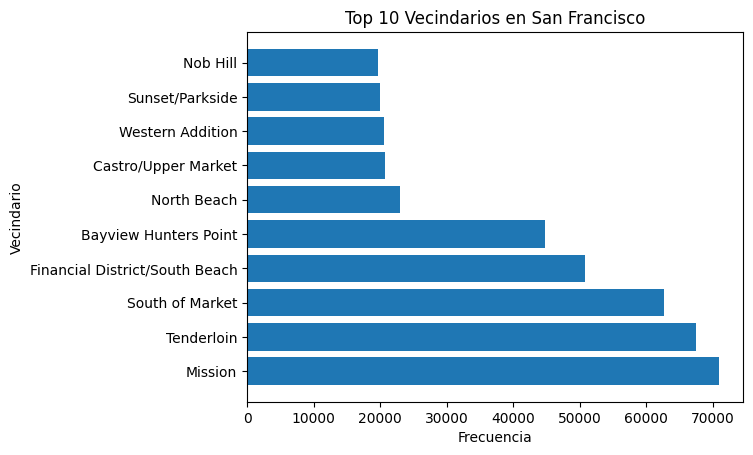

In [39]:
top_10_neighborhoods = neighborhood_counts.head(10)

plt.barh(top_10_neighborhoods.index, top_10_neighborhoods.values)
plt.xlabel('Frecuencia')
plt.ylabel('Vecindario')
plt.title('Top 10 Vecindarios en San Francisco')
plt.show()

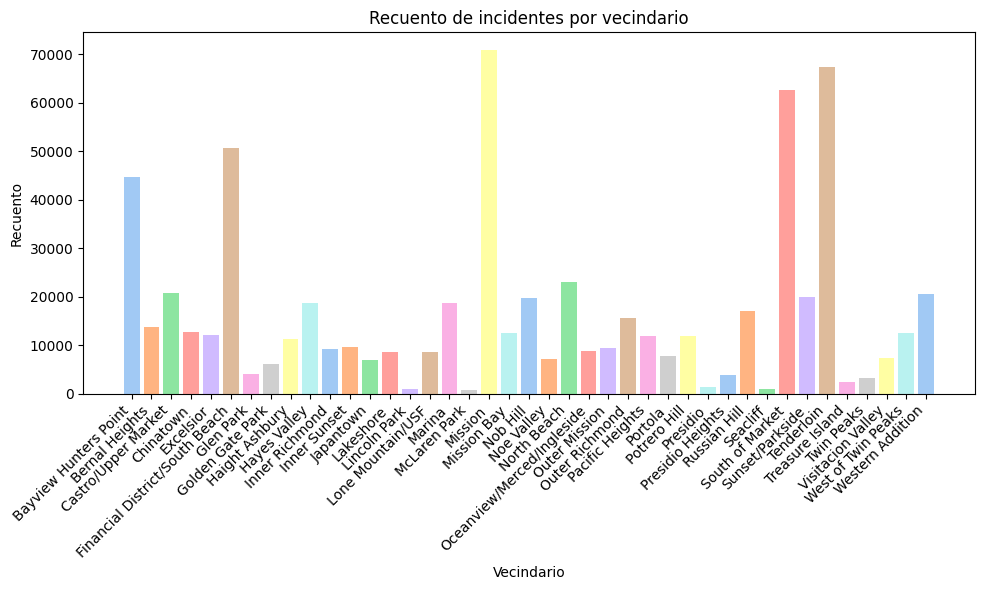

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

incident_counts = Incidents_P['neighborhood'].value_counts()
incident_counts = incident_counts.sort_index()

colors = sns.color_palette("pastel")

plt.figure(figsize=(10, 6))

# Graficar las barras
plt.bar(incident_counts.index, incident_counts, color=colors)

plt.title('Recuento de incidentes por vecindario')
plt.xlabel('Vecindario')
plt.ylabel('Recuento')

# Ajustar la rotación de las etiquetas del eje x
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


### Street<a name="Street"></a>

Visualizamos los distintos valores de la variable Street de nuestro conjunto de datos. 

In [40]:
street_counts = Incidents_P['Street'].value_counts()
print(street_counts)

Street
Eddy Street         14807
Turk Street         14113
16th Street         11889
4th Street          10995
Market Street        9242
                    ...  
Fernandez Street        1
Letterman Drive         1
Eaton Place             1
Rodriguez Street        1
Jauss Street            1
Name: count, Length: 1346, dtype: int64


A continuación mostramos el resultado anterior de forma gráfica.

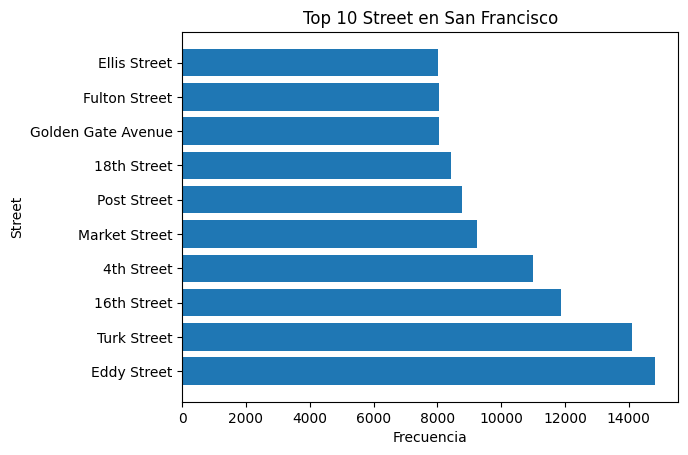

In [41]:
top_10_street = street_counts.head(10)

plt.barh(top_10_street.index, top_10_street.values)
plt.xlabel('Frecuencia')
plt.ylabel('Street')
plt.title('Top 10 Street en San Francisco')
plt.show()

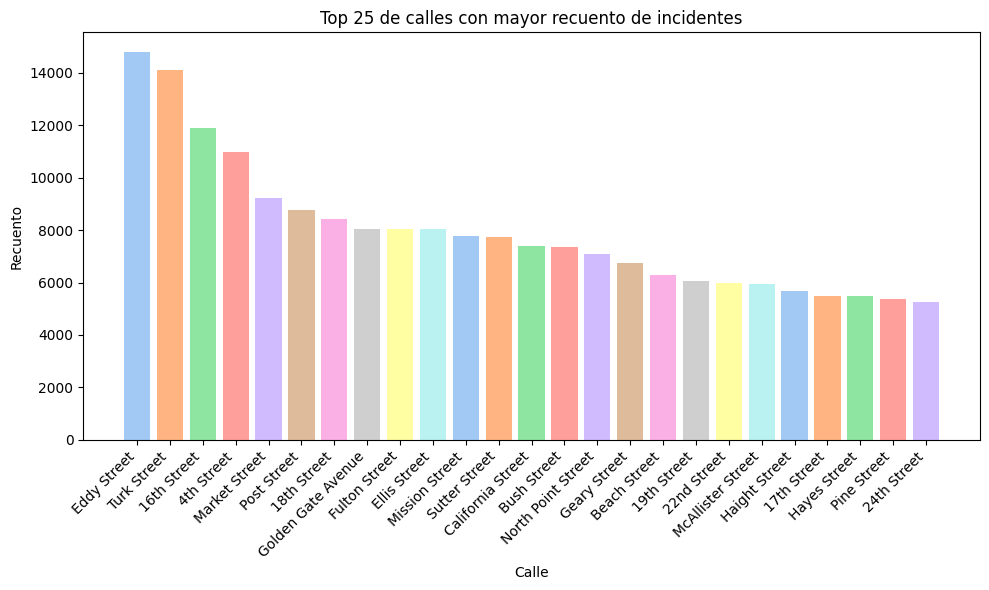

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

incident_counts = Incidents_P['Street'].value_counts()
top_25 = incident_counts.head(25)

colors = sns.color_palette("pastel")

plt.figure(figsize=(10, 6))

# Graficar las barras
plt.bar(top_25.index, top_25, color=colors)

plt.title('Top 25 de calles con mayor recuento de incidentes')
plt.xlabel('Calle')
plt.ylabel('Recuento')

# Ajustar la rotación de las etiquetas del eje x
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


Observamos que las calles más frecuentes ne nuestro conjunto de datos son Eddy Street, Turk Street, 16th Street y 4th Street. 

Por último, vamos a renombrar el valor 'No calculado' de la variable calle ya que en la función que empleamos en el ACTA3. Preprocesado de los datos si nose calculaba la calle nos devolvía el valor 'No calculado'. Con este cambio podremos imputar los faltantes correctamente. 

In [42]:
Incidents_P['Street'].replace('No calculado', np.nan, inplace=True)

### Police district<a name="Police district"></a>

Mostramos un recuento de los valores de la columna Police_district.

In [43]:
pd_counts = Incidents_P['Police_district'].value_counts()
print(pd_counts)

Police_district
CENTRAL       102722
NORTHERN       96909
MISSION        87961
SOUTHERN       86192
TENDERLOIN     65411
BAYVIEW        63880
INGLESIDE      52568
TARAVAL        51696
RICHMOND       39193
PARK           30936
Name: count, dtype: int64


Observamos que los distritos más frecuentes son 'CENTRAL', 'NORTHERN', 'MISSION' y 'SOUTHERN'. Vamos a representarlo de forma gráfica.

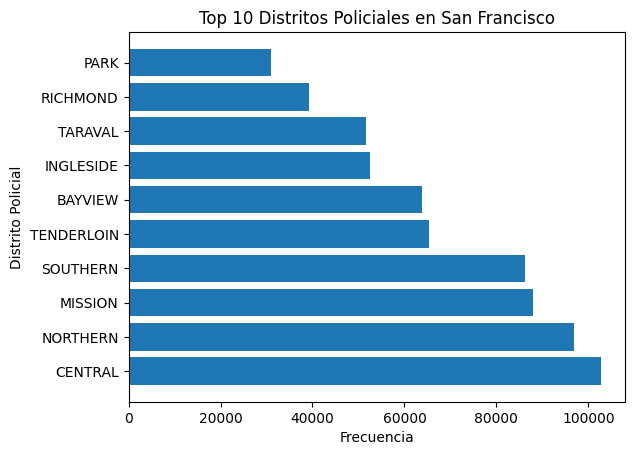

In [44]:
top_10_pd = pd_counts.head(10)

plt.barh(top_10_pd.index, top_10_pd.values)
plt.xlabel('Frecuencia')
plt.ylabel('Distrito Policial')
plt.title('Top 10 Distritos Policiales en San Francisco')
plt.show()

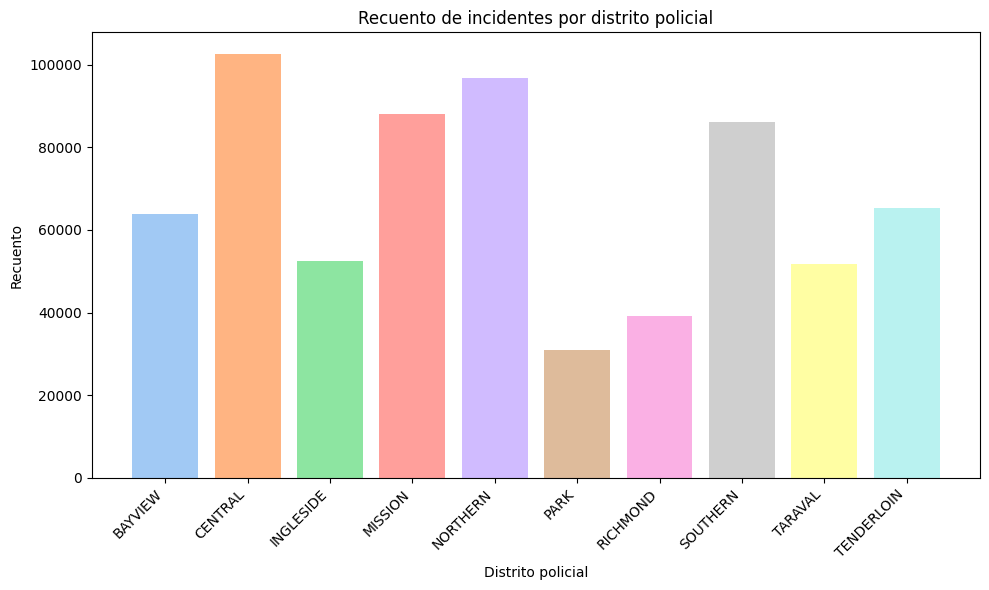

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

incident_counts = Incidents_P['Police_district'].value_counts()
incident_counts = incident_counts.sort_index()

colors = sns.color_palette("pastel")

plt.figure(figsize=(10, 6))

# Graficar las barras
plt.bar(incident_counts.index, incident_counts, color=colors)

plt.title('Recuento de incidentes por distrito policial')
plt.xlabel('Distrito policial')
plt.ylabel('Recuento')

# Ajustar la rotación de las etiquetas del eje x
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


### Holiday<a name="Holiday"></a>

Empezamos haciendo un reucento de los valores de esta columna

In [45]:
holiday_counts = Incidents_P['Holiday'].value_counts()
print(holiday_counts)

Holiday
Both    27996
Name: count, dtype: int64


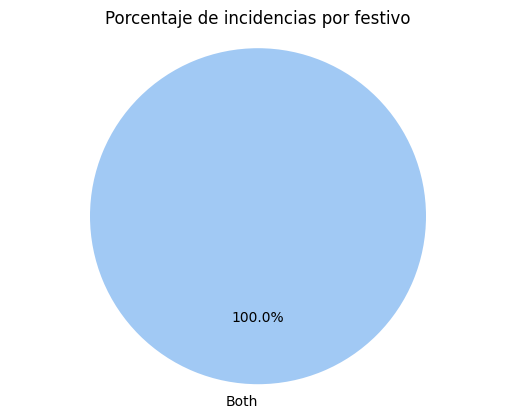

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("pastel")

labels = Incidents_P['Holiday'].value_counts().index

plt.pie(Incidents_P['Holiday'].value_counts(), labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')

plt.title('Porcentaje de incidencias por festivo')

plt.axis('equal')  # Para asegurar que el gráfico sea circular

plt.show()


Vemos que en nuestro conjunto de datos tenemos 27996 días festivos tanto para Claifornoa como para San Francisco.

### Estudio y tratamiento valores atípicos y anómalos<a name="Estudio-y-tratamiento-valores-atípicos-y-anómalos"></a>

En esta parte de la limpieza descartaremos las variables Neighborhood y Police district ya que han sido calculadas a partir de datos actuales publicados en la pataforma OpenDataSF. 

Estudiaremos la existencia de valores atípicos y anómalos para las variables Holiday y Street. 

### Holiday

Anteriormente habíamos visto que únicamente teníamos valores None y Both en nuestra variable. Recordemos que el valor Both indicaba que el festivo era común tanto para California como para San Francisco. 

Parece extraño que desde el año 2018 al año 2024 todos los festivos sean para California y para San Francisco. 

Para corroborar que esto cierto recurriremos a la librería que nos sirvió en su día para calcular la variable y vamos a ver si todos los días festivos en California también han sido festivos en San Francisco. 

In [46]:


start_year = 2018
end_year = 2023

ca_holidays = holidays.US(years=range(start_year, end_year + 1))
sf_holidays = holidays.US(state='CA', years=range(start_year, end_year + 1))

for year in range(start_year, end_year + 1):
    ca_holiday_set = set(holiday[0] for holiday in ca_holidays.items() if holiday[0].year == year)
    sf_holiday_set = set(holiday[0] for holiday in sf_holidays.items() if holiday[0].year == year)
    
    if ca_holiday_set == sf_holiday_set:
        print(f"El año {year} tiene los mismos festivos en California y San Francisco.")
    else:
        print(f"El año {year} no tiene los mismos festivos en California y San Francisco.")


El año 2018 no tiene los mismos festivos en California y San Francisco.
El año 2019 no tiene los mismos festivos en California y San Francisco.
El año 2020 no tiene los mismos festivos en California y San Francisco.
El año 2021 no tiene los mismos festivos en California y San Francisco.
El año 2022 no tiene los mismos festivos en California y San Francisco.
El año 2023 no tiene los mismos festivos en California y San Francisco.


Observamos que no todos los festivos coinciden, esto quiere decir que la función que aplicamos en el preprocesado no estaba realizada correctamente. 
Para corregir este error vamos a crear una función y en este caso sólo tendrá en cuenta si el festivo es en San Francisco. 

In [19]:
sf_holidays = holidays.US(state='CA', years=range(2018, 2024))

def es_festivo_sf(fecha):
    if sf_holidays.get(fecha):
        return "Yes"
    else:
        return "No"

Aplicamos la función a nuestro conjunto de datos y visualizamos los resultados

In [20]:
Incidents_P['Holiday'] = Incidents_P['incident_datetime'].apply(lambda x: es_festivo_sf(x.date()))


In [21]:
holiday_counts = Incidents_P['Holiday'].value_counts()
print(holiday_counts)

Holiday
No     650129
Yes     27996
Name: count, dtype: int64


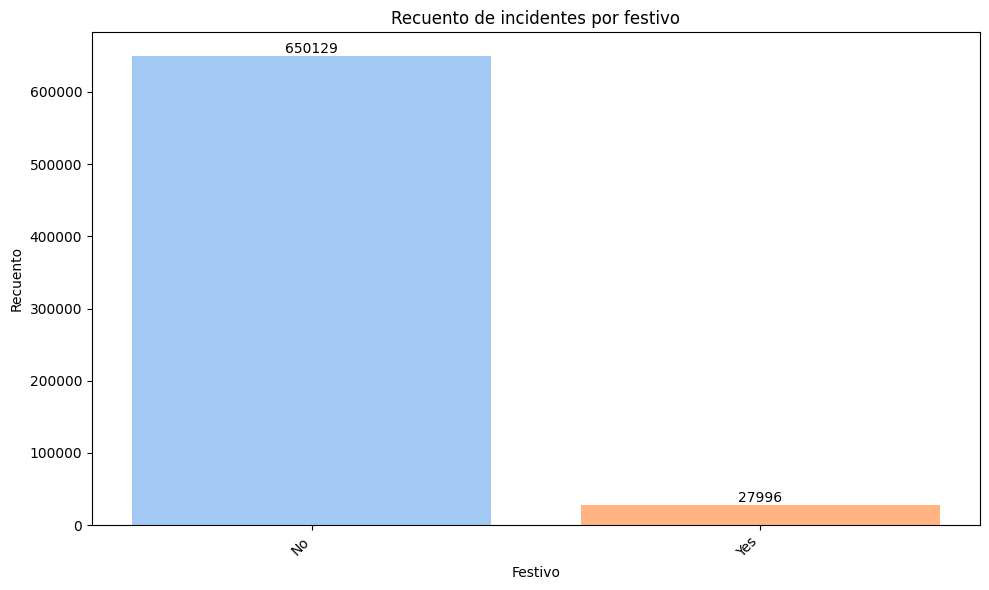

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

incident_counts = Incidents_P['Holiday'].value_counts()
incident_counts = incident_counts.sort_index()

colors = sns.color_palette("pastel")

plt.figure(figsize=(10, 6))

# Graficar las barras
bars = plt.bar(incident_counts.index, incident_counts, color=colors)

plt.title('Recuento de incidentes por festivo')
plt.xlabel('Festivo')
plt.ylabel('Recuento')

# Ajustar la rotación de las etiquetas del eje x
plt.xticks(rotation=45, ha='right')

# Agregar etiquetas con los valores en cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')

plt.tight_layout()
plt.show()


Vemos que tenemos 27996 días de nuestro conjunto de datos que son días Festivos. 

### Street 

Para analizar si existen datos anómalos o atípicos en nuestro conjunto de datos procederemos a emplear el archivo Street_Names descargado en el ACTA1. Obtención y extracción de los datos. 

En este archivo tenemos las diferentes calles, avenizas, parques y plazas de San Francisco.  Comprobaremos si los distintos valores de nuestra columna Street aparecen en eeste conjunto de datos. 

Comenzamos visualizando las primeras 5 líneas del archivo Street Names para ver lo que tenemos en él y como podemos emplear esta información. 

In [50]:
street_file = pd.read_csv('Street_Names.csv')
street_file.head()

,FullStreetName,StreetName,StreetType,PostDirection
0,01ST ST,01ST,ST,NaN
1,02ND AVE,02ND,AVE,NaN
2,02ND ST,02ND,ST,NaN
3,02ND TI ST,02ND TI,ST,NaN
4,03RD AVE,03RD,AVE,NaN


Podemos ver que tenemos 4 columnas:

- FullStreetName, que incluye el nombre completo de la calle
- StreetName, que cotiene únicamente el nombre de la calle excluendo el tipo de calle de la columna anterior. 
- StreetType, que contiene una abreviatura deltipo de calle. 


Vamos a revisar como es el formato de nuestras calles para ver como podemos comparar las cadenas de texto. 


In [51]:
print(Incidents_P['Street'][:5])

0    Fulton Street
1      16th Street
2        Navy Road
3    Sadowa Street
4      Hyde Street
Name: Street, dtype: category
Categories (1345, object): ['10th Avenue', '10th Street', '11th Avenue', '11th Street', ..., 'Yosemite Avenue', 'Yukon Street', 'Zircon Place', 'Zoe Street']


Observamos que en nuestra conjunto de datos tenemos tenemos el nombre de la calle más el tipo de la calle pero el tipo de la calle no se encuentra abreviado, por lo que para poder comparar hemos de transformar la columna Street de nuestros datos.

Para ello, convertiré mi variable mediante un diccionario en el que tendré para cada tipo de calle extendido la abreviatura, convertiré el tipo de calle extendido de mi columna en el tipo de calle abreviado.

In [52]:

street_type_mapping = {
    'Street': 'St',
    'Avenue': 'Ave',
    'Place': 'Pl',
    'Circle': 'Cir',
    'Road': 'Rd',
    'Court': 'Ct',
    'Lane': 'Ln',
    'Alley': 'Aly',
    'Boulevard': 'Blvd',
    'Drive': 'Dr',
    'Loop': 'Loop',
    'Park': 'Park',
    'Path': 'Path',
    'Plaza': 'Plz',
    'Ramp': 'Ramp',
    'Steps': 'Stps',
    'Stairway': 'Stwy',
    'Terrace': 'Ter',
    'Tunnel': 'Tunl',
    'Walk': 'Walk',
    'Way': 'Way',
    'Crossing': 'Xing'
}


def abbreviate_street_type(street):
    words = street.split()
    if len(words) > 1:
        last_word = words[-1]
        if last_word in street_type_mapping:
            words[-1] = street_type_mapping[last_word]
            return ' '.join(words)
    return street.upper()


Incidents_P['Street'] = Incidents_P['Street'].apply(abbreviate_street_type)
Incidents_P['Street'] = Incidents_P['Street'].str.upper()
Incidents_P['Street']


0         FULTON ST
1           16TH ST
2           NAVY RD
3         SADOWA ST
4           HYDE ST
            ...    
678120     BEACH ST
678121    ORTEGA ST
678122    CASTRO ST
678123     HAYES ST
678124     LINDA ST
Name: Street, Length: 678125, dtype: object

Una vez transformada nuestra variable lo que haremos será comparar que todas nuestras calles coinciden con las calles que tenemos en el archivo descargado. 
Crearé una función que me diga si una calle es atípica si no la encuentra dentro de dicho archivo. 

In [53]:
Incidents_P['Street']= Incidents_P['Street'].astype('category')
def is_atypical_street(street):
    if street in street_file['FullStreetName'].tolist():
        return 'NO'
    else:
        street_name = street.split()[:-1]
        street_type = street.split()[-1]
        if street_type in street_type_mapping.keys():
            street_name.append(street_type_mapping[street_type])
        if street_name in street_file['StreetName'].tolist():
            return 'NO'
    return 'ATYPICAL'


Incidents_P['Street_Atypical'] = Incidents_P['Street'].apply(is_atypical_street)

Vamos a visualizar qué resultados nos ha devuelto nuestra función.

In [54]:
Incidents_P['Street_Atypical'].value_counts()

Street_Atypical
NO          596773
ATYPICAL     42381
Name: count, dtype: int64

Observamos que tenemos 46587 calles que no se están encontrando en el archivo que contiene todas las calles de San Francisco. 
Mostramos algunos de estos registros para ver si puede ser la presencia de algún carácter especial en la cadena de texto.

In [55]:
filetered_data = Incidents_P[Incidents_P['Street_Atypical']=='ATYPICAL']
print(filetered_data['Street'][:5])

6                    4TH ST
51                   4TH ST
68    CHARLES J. BRENHAM PL
75             O'FARRELL ST
86               VERMEHR PL
Name: Street, dtype: category
Categories (1345, object): ['10TH AVE', '10TH ST', '11TH AVE', '11TH ST', ..., 'YOSEMITE AVE', 'YUKON ST', 'ZIRCON PL', 'ZOE ST']


Cogemos de ejemplo el registro 68 y vamos a buscar si hay algún registro del archivo de OpenDataSF que contenga la cadena BRENHAM. Cogemos este regitro porque Brenham es un nombre propio y si no está no devolverá varios registros. 

In [56]:
filtered_data = street_file[street_file['FullStreetName'].str.contains('BRENHAM', case=False)]
print(filtered_data['FullStreetName'])


497    CHARLES J BRENHAM PL
Name: FullStreetName, dtype: object


Como vemos, la calle si que existe pero no contiene el carácter '.' que tenemos en nuestro conjunto de datos. 
Vamos a volver a ejecutar la función de antes pero modificándola para que antes elimine los carácteres especiales tanto de nuestro conjunto de datos como del conjunto de datos con las calles correctas.

In [57]:


def is_atypical_street(street):
    
    street = re.sub(r'\W+', '', street)

  
    street_file['FullStreetName'] = street_file['FullStreetName'].apply(lambda x: re.sub(r'\W+', '', x))

    if street in street_file['FullStreetName'].tolist():
        return 'NO'
    else:
        street_name = street.split()[:-1]
        street_type = street.split()[-1]
        if street_type in street_type_mapping.keys():
            street_name.append(street_type_mapping[street_type])
        street_name = ' '.join(street_name)

        street_file['StreetName'] = street_file['StreetName'].apply(lambda x: re.sub(r'\W+', '', x))

        if street_name in street_file['StreetName'].tolist():
            return 'NO'
    return 'ATYPICAL'

Incidents_P['Street_Atypical'] = Incidents_P['Street'].apply(is_atypical_street)


In [58]:
Incidents_P['Street_Atypical'].value_counts()

Street_Atypical
NO          603619
ATYPICAL     35535
Name: count, dtype: int64

Vemos que hemos conseguido reducir el número de atípicos pero que seguimos teniendo atípicos. Parece ser que las calles no están nombradas de la misma forma entre nuestro conjunto de datos y el conjunto de datos del OpenDataSF. 
Para comprobar que no es únicamente la presencia de carácteres vamos a calcular un índice de similitud entre nuestras calles y la calle más parecida en el conjunto de datos descargado con los nombres correctos de las calles. 

Esto lo haremos mediante la librería fuzzywuzzy que nos permitirá buscar de forma eficiente la cadena más cercana y calcular el indice de similitud. 
Calcularemos dos columnas, una con la calle más parecida y otra con el ratio. Posteriormente estudiaremos estos ratios. 

In [59]:
from fuzzywuzzy import fuzz
filetered_data = Incidents_P[Incidents_P['Street_Atypical']=='ATYPICAL']


filetered_data['SimilarStreet'] = ''
filetered_data['SimilarityIndex'] = 0


for index, row in filetered_data.iterrows():
    incident_street = row['Street']
    max_similarity = 0
    similar_street = ''
    

    for _, street_row in street_file.iterrows():
        fullname_street = street_row['FullStreetName']
        similarity = fuzz.ratio(incident_street, fullname_street)
        
       
        if similarity > max_similarity:
            max_similarity = similarity
            similar_street = fullname_street
    
    
    filetered_data.at[index, 'SimilarStreet'] = similar_street
    filetered_data.at[index, 'SimilarityIndex'] = max_similarity


result_df = filetered_data[['Street', 'SimilarStreet', 'SimilarityIndex']]

print(result_df.head())


C:\Users\fatima.elaouni\AppData\Local\Temp\ipykernel_25060\2640784725.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filetered_data['SimilarStreet'] = ''
C:\Users\fatima.elaouni\AppData\Local\Temp\ipykernel_25060\2640784725.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filetered_data['SimilarityIndex'] = 0


     Street SimilarStreet  SimilarityIndex
6    4TH ST        04THST               83
51   4TH ST        04THST               83
127  4TH ST        04THST               83
153  4TH ST        04THST               83
166  3RD ST        03RDST               83


Ahora compararemos la longitud de ambas listas, si todas nuestras calles atípicas son de San Francisco se habrán añadido a la lista sf_streets. También mostraremos la diferencia entre ambas listas. 

In [60]:
min_similarity = min(result_df['SimilarityIndex'])
max_similarity = max(result_df['SimilarityIndex'])
print(f"Mínimo índice de similitud: {min_similarity}")
print(f"Máximo índice de similitud: {max_similarity}")

Mínimo índice de similitud: 43
Máximo índice de similitud: 93


In [61]:
result_df['SimilarityIndex'].value_counts().sort_index()

SimilarityIndex
43      227
62        9
67      682
69       37
70      104
71       68
72       29
75       32
76      183
77       91
78       88
79        5
80       12
81        2
82       60
83    29119
85     1249
86     3088
88      336
92      104
93       10
Name: count, dtype: int64

In [62]:

value_counts = result_df['SimilarityIndex'].value_counts().sort_index()
for similarity_index, count in value_counts.items():
    subset = result_df[result_df['SimilarityIndex'] == similarity_index]
    street_value = subset['Street'].iloc[0]
    correct_street = subset['SimilarStreet'].iloc[0]
    print(f"Similarity Index: {similarity_index}")
    print(f"Count: {count}")
    print(f"Street Value: {street_value}")
    print(f"Correct Street: {correct_street}")
    print()

Similarity Index: 43
Count: 227
Street Value: OCTAVIA BOULEVARD BIKE CONNECTOR
Correct Street: AMBROSEBIERCEST

Similarity Index: 62
Count: 9
Street Value: SKUNK ALY
Correct Street: PINKALY

Similarity Index: 67
Count: 682
Street Value: ECKER PLZ
Correct Street: DECKERALY

Similarity Index: 69
Count: 37
Street Value: MIDDLE DRIVE WEST
Correct Street: MIDDLEWESTDR

Similarity Index: 70
Count: 104
Street Value: CLEO RAND LN
Correct Street: CLEORANDAVE

Similarity Index: 71
Count: 68
Street Value: GOLDEN GATE BRIDGE
Correct Street: GOLDENGATEAVE

Similarity Index: 72
Count: 29
Street Value: CHAIN OF LAKES DRIVE EAST
Correct Street: CHAINOFLAKESDR

Similarity Index: 75
Count: 32
Street Value: BURNETT NORTH AVE
Correct Street: BURNETTAVENORTH

Similarity Index: 76
Count: 183
Street Value: GREAT HIGHWAY
Correct Street: GREATHWY

Similarity Index: 77
Count: 91
Street Value: COLIN P. KELLY JUNIOR ST
Correct Street: COLINPKELLYJRST

Similarity Index: 78
Count: 88
Street Value: LA PLAYA ST
Corre

Como observamos, parece que las cadenas desde una similitud de 43 hasta una similitud 69, las cadenas difieren bastante pero para el resto de similitudes si que las cadenas parecen hacer referencia a la misma calle. 

Dado que hemos empleado la librería de Geopy y hemos encontrado en  varias páginas webs que es una librería muy popular entre los programadores en python para la geocodificación como en la página https://mappinggis.com/2022/04/15-librerias-de-python-para-gis/#7_GeoPy o en https://mappinggis.com/2018/11/geocodificacion-con-geopy/ dónde se explica tanto su uso popular como las instrucciones de uso. 


En resumen no hemos encontrado datos atípicos ni en la variable Holiday ni en la variable Street por lo que podemos pasar a hacer un estudio de los valores faltantes de nuestro conjunto de datos. 

### Estudio y tratamiento valores faltantes<a name="Estudio-y-tratamiento-valores-faltantes"></a>

Ahora continuaremos revisando si existen datos faltantes en nuestro conjunto de datos y cómo podemos tratarlos.

In [63]:
null_count = Incidents_P[['neighborhood', 'Police_district', 'Holiday', 'Street']].isnull().sum()
print(null_count)

neighborhood         132
Police_district      657
Holiday                0
Street             38971
dtype: int64


Podemos ver que tenemos valores faltantes tanto en la columna neighborhood, como POlice_district como Street. 
Vamos a visualizar de forma gráfica estos registros para cada una de nuestras variables para ver si corresponden a una misma zona

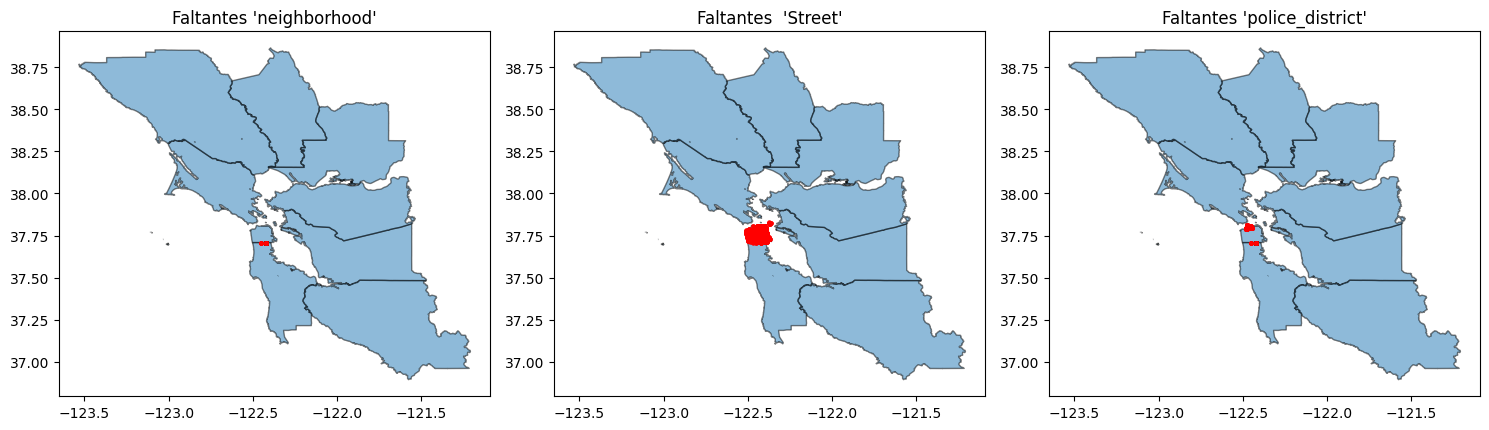

In [64]:
bay_counties = gpd.read_file('Bay Area Counties.geojson')
fig, axs = plt.subplots(1, 3, figsize=(15, 5))


data_null_n = Incidents_P.loc[Incidents_P['neighborhood'].isnull()]
gdf = gpd.GeoDataFrame(data_null_n, geometry=gpd.points_from_xy(data_null_n.longitude, data_null_n.latitude))
bay_counties.plot(ax=axs[0], alpha=0.5, edgecolor='k')
gdf.plot(ax=axs[0], color='red', markersize=5)
axs[0].set_title("Faltantes 'neighborhood'")


data_null_s = Incidents_P.loc[Incidents_P['Street'].isnull()]
gdf = gpd.GeoDataFrame(data_null_s, geometry=gpd.points_from_xy(data_null_s.longitude, data_null_s.latitude))
bay_counties.plot(ax=axs[1], alpha=0.5, edgecolor='k')
gdf.plot(ax=axs[1], color='red', markersize=5)
axs[1].set_title("Faltantes  'Street'")


data_null_p = Incidents_P.loc[Incidents_P['Police_district'].isnull()]
gdf = gpd.GeoDataFrame(data_null_p, geometry=gpd.points_from_xy(data_null_p.longitude, data_null_p.latitude))
bay_counties.plot(ax=axs[2], alpha=0.5, edgecolor='k')
gdf.plot(ax=axs[2], color='red', markersize=5)
axs[2].set_title("Faltantes 'police_district'")


plt.tight_layout()


plt.show()


Podemos observar que los registros con valores faltantes en nuestros datos corresponden a una misma área dentro del polígono de San Francisco. Esto se debe a que los archivos utilizados para calcular el vecindario y el distrito policial no incluyen todos los puntos geográficos presentes en el archivo "Bay Area Country" que define el polígono de San Francisco.

Esta información fue proporcionada por el responsable del Departamento de Planificación de San Francisco en respuesta a mi solicitud de información sobre cómo determinar si un punto pertenece a San Francisco. El responsable mencionó que los archivos de distritos policiales y vecindarios no incluían algunas áreas que delimitan San Francisco.

Por esta razón, hemos decidido mantener estos datos y no eliminarlos, ya que el patrón de valores faltantes no es aleatorio, sino que se debe a que son registros de una zona específica de San Francisco que no es considerada como área metropolitana.

Como eliminaremos estos casos tendremos que realizar una imputación para que podamos incluir estos datos en el estudio. 

Imputaremos el siguiente valor para cada variable cuando el resgitro pertenezca a esta zona:

1. Street: 'Unkown Street'

2. Neighborhood: 'Periphery Zone'

3. Police District: 'Outside District Boundaries'


In [66]:
Incidents_P['Street'] = Incidents_P['Street'].astype('object')
Incidents_P['neighborhood'] = Incidents_P['neighborhood'].astype('object')
Incidents_P['Police_district'] = Incidents_P['Police_district'].astype('object')

Incidents_P.loc[Incidents_P['Street'].isnull(), 'Street'] = 'Unknown Street'
Incidents_P.loc[Incidents_P['neighborhood'].isnull(), 'neighborhood'] = 'Periphery Zone'
Incidents_P.loc[Incidents_P['Police_district'].isnull(), 'Police_district'] = 'Outside District Boundaries'

null_count = Incidents_P[['neighborhood', 'Police_district', 'Holiday', 'Street']].isnull().sum()
print(null_count)


neighborhood       0
Police_district    0
Holiday            0
Street             0
dtype: int64


In [67]:
Incidents_P['Street'].value_counts()

Street
Unknown Street    38971
EDDY ST           14807
TURK ST           14113
16TH ST           11889
4TH ST            10995
                  ...  
WISSER CT             1
SHERMAN RD            1
BROOKS ST             1
LETTERMAN DR          1
BROWN ST              1
Name: count, Length: 1346, dtype: int64

Como vemos ya tenemos nuestro conjunto de datos sin ningún valor faltante. Procedemos a eliminar las variables calculadas para el estudi de atípicos y guardamos nuestro conjunto de datos para que lo empleemos en un futuro en la parte 2 del peprocesado en el que se codifiquen las variables. 

In [68]:
Incidents_P.drop(columns=['Street_Atypical'],inplace=True)


In [69]:
Incidents_P.to_csv('Incidents_Clean.csv')

### Estudio relaciones entre variables<a name="Estudio-relaciones-entre-variables"></a>

A continuación realizaremos un estudio para detectar si existen relaciones entre nuestro conjunto de datos y las variables candidatas a ser predictoras. 

Para hacer este análisis de variables realizaremos contrastes estadísticos de chi cuadrado para cada par de variables y posteriormente aplicaremos regresión para las variables de interés y así poder detectar posibles relaciones. 

Comenzaremos con los contrastes de hipótesis. Las hipótesis de este contraste son:

- Hipótesis nula: no hay relación entre las variables
- Hipótesis alternativa: existe relación ente ambas variables

Para que se rechace la hipótesis nula y concluyamos que existe una relación el p-value tiene que ser menor que 0.05 que será nuestro nivel de significancia. 

Aplicamos este contraste para todas las variables y lo almacenaremos en un datafarame para posteriormente analizar los resultados.

In [70]:
from itertools import combinations
from scipy.stats import chi2_contingency


todas_las_columnas = Incidents_P.columns.tolist()


columnas_a_omitir = ['latitude', 'longitude']


columnas_a_estudiar = [c for c in todas_las_columnas if c not in columnas_a_omitir]


resultados = {}


for columna_a, columna_b in combinations(columnas_a_estudiar, 2):
    tabla_contingencia = pd.crosstab(Incidents_P[columna_a], Incidents_P[columna_b])
    chi2, pval, dof, expected = chi2_contingency(tabla_contingencia)
    resultados[columna_a + ' vs ' + columna_b] = {'test_chi': chi2, 'p-value': pval}



In [71]:
import pandas as pd


df_resultados = pd.DataFrame.from_dict(resultados, orient='index')


df_resultados = df_resultados.sort_values(by=['p-value'], ascending=True)


print(df_resultados)
df_resultados.shape

                                                  test_chi        p-value
incident_datetime vs incident_day_of_week     4.068750e+06   0.000000e+00
incident_code vs neighborhood                 3.259640e+05   0.000000e+00
incident_code vs Police_district              1.967788e+05   0.000000e+00
Police_district vs Street                     4.970672e+06   0.000000e+00
incident_code vs Street                       1.799361e+06   0.000000e+00
incident_category vs incident_subcategory     2.470720e+07   0.000000e+00
incident_category vs resolution               3.849123e+05   0.000000e+00
incident_category vs neighborhood             1.541960e+05   0.000000e+00
incident_category vs Police_district          9.953119e+04   0.000000e+00
neighborhood vs Police_district               4.865385e+06   0.000000e+00
incident_category vs Street                   3.689805e+05   0.000000e+00
incident_subcategory vs resolution            3.435726e+05   0.000000e+00
incident_subcategory vs neighborhood  

(45, 2)

Ahora seleccionamos sólo las variables que tienen relación entre sí.

In [72]:
selected_rows = df_resultados[df_resultados['p-value'] < 0.05]
print(selected_rows)

                                                  test_chi        p-value
incident_datetime vs incident_day_of_week     4.068750e+06   0.000000e+00
incident_code vs neighborhood                 3.259640e+05   0.000000e+00
incident_code vs Police_district              1.967788e+05   0.000000e+00
Police_district vs Street                     4.970672e+06   0.000000e+00
incident_code vs Street                       1.799361e+06   0.000000e+00
incident_category vs incident_subcategory     2.470720e+07   0.000000e+00
incident_category vs resolution               3.849123e+05   0.000000e+00
incident_category vs neighborhood             1.541960e+05   0.000000e+00
incident_category vs Police_district          9.953119e+04   0.000000e+00
neighborhood vs Police_district               4.865385e+06   0.000000e+00
incident_category vs Street                   3.689805e+05   0.000000e+00
incident_subcategory vs resolution            3.435726e+05   0.000000e+00
incident_subcategory vs neighborhood  

Parece que tenemos relaciones entre casi cada par de variables. Para verlo más claro vamos a extraer aquellas variables que aparecen más veces para ver cuáles son las que más relaciones tienen con otras variables. 

In [73]:
variable_count = pd.Series(selected_rows.index.str.split(' vs ').str[0].tolist() + selected_rows.index.str.split(' vs ').str[1].tolist()).value_counts()
print(variable_count)

Police_district         9
incident_category       9
neighborhood            9
incident_subcategory    9
resolution              9
incident_day_of_week    9
Holiday                 9
Street                  9
incident_datetime       8
incident_code           8
Name: count, dtype: int64


Observamos que todas estan correlacionadas. 

Finalmente hasta este punto hemos conseguido hacer la limpieza completa de nuestro conjunto de datos. Procedemos a guardar nuestro conjunto de datos reusltante. 

In [74]:
missing_values_count = Incidents_P.isna().sum()
print(missing_values_count)

incident_datetime       0
incident_day_of_week    0
incident_code           0
incident_category       0
incident_subcategory    0
resolution              0
latitude                0
longitude               0
neighborhood            0
Police_district         0
Holiday                 0
Street                  0
dtype: int64


In [ ]:
Incidents_P.to_csv("Incidents_SF.csv",index=False)


El próximo paso será aplicar la segunda parte del preprocesado para conseguir codificar nuestras variables y tuener nuestros datos preparados para construir sobre ellos nuestros modelos estadísticos. 